# Dataset: Baseball Players

In this lab, we will use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.




In [312]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from plotnine import *
import warnings
from sklearn.exceptions import ConvergenceWarning

#suppress convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)
pd.options.mode.chained_assignment = None

In [313]:
# import data
hitters = pd.read_csv("Hitters.csv")

# drop na values
hitters.dropna(inplace=True)

# Part 1: Different Model Specs

## Part A: Regression without Regularization

In [314]:
# write function that tunes regression

def tune_regression(X, y, model_type = "linear", alpha_values = [0.001, 0.01, 0.1, 1, 10], l1_ratio_values = [0.0, 0.25, 0.5, 0.75, 1.0], cv = 5, interaction = False):

    # create criteria for model specification
    if model_type  == "linear":
        model = LinearRegression()
        alpha = {}
        l1_ratio = {}
    elif model_type == "ridge":
        model = Ridge()
        alpha = {"regression__alpha": alpha_values}
        l1_ratio = {}
    elif model_type == "lasso":
        model = Lasso()
        alpha = {"regression__alpha": alpha_values}
        l1_ratio = {}
    elif model_type == "elasticnet":
        model = ElasticNet()
        alpha = {"regression__alpha": alpha_values, "regression__l1_ratio": l1_ratio_values}
    else:
        raise ValueError("Unsupported model_type. Choose from 'lasso', 'ridge', 'elasticnet', or 'linear'.")

    # create pipeline
    ct = ColumnTransformer([("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
                                        make_column_selector(dtype_include=object)),
                            ("standardize", StandardScaler(), 
                                        make_column_selector(dtype_include=np.number))],
                                        remainder = "passthrough")

    pipeline = Pipeline([
        ("preprocessing", ct), 
        ("regression", model)
    ])
    
    # do grid search
    grid_search = GridSearchCV(pipeline, alpha, cv=cv, scoring='neg_mean_squared_error')
    grid_search_fitted = grid_search.fit(X, y)

    # get best model
    best_model = grid_search.best_estimator_
    best_model_fitted = best_model.fit(X, y)

    # get coefs and var names
    coefs = best_model.named_steps['regression'].coef_
    feature_names = best_model_fitted.named_steps['preprocessing'].get_feature_names_out()

    # create df to store coefs
    coefs_df = pd.DataFrame({
        "Feature Name": feature_names,
        "Coefficients": coefs})

    print("Cross-validated MSE scores:", -grid_search_fitted.cv_results_['mean_test_score'])

    # extract best model values
    best_alpha = grid_search.best_params_.get("regression__alpha", None)
    best_l1_ratio = grid_search.best_params_.get("regression__l1_ratio", None)
    best_score = grid_search.best_score_
    
    # print best alpha and l1_ratio scores if applicable
    if best_alpha is not None:
        print(f"Best alpha: {best_alpha}")
    if best_l1_ratio is not None:
        print(f"Best l1 ratio: {best_l1_ratio}")
    print(f"Best cross-validated MSE score: {-best_score}")
    sorted_coefs_df = coefs_df.sort_values(by='Coefficients', key = abs, ascending=False)

    
    return sorted_coefs_df

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression
2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.
3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [315]:
# create variables
X = hitters.drop(["Salary"], axis = 1)
y = hitters["Salary"]

tune_regression(X, y, model_type = "linear")

Cross-validated MSE scores: [121136.31031817]
Best cross-validated MSE score: 121136.3103181688
Cross-validated MSE scores: [121136.31031817]
Best cross-validated MSE score: 121136.3103181688


,Feature Name,Coefficients
16,standardize__CRuns,480.747135
13,standardize__CAtBat,-391.038655
7,standardize__Hits,337.830479
6,standardize__AtBat,-291.094556
17,standardize__CRBI,260.689886
18,standardize__CWalks,-213.892259
11,standardize__Walks,135.073897
14,standardize__CHits,86.687617
19,standardize__PutOuts,78.761296
9,standardize__Runs,-60.572479


### Interpretations:
* For each additional career run, a player's salary is expected to increase by $480,750.
* For each additional career at-bat, a player's salary is expected to decrease by $391,040
* For each additional hit a player made in 1986, their salary is expected to increase by $337,830.
* For each additional at-bat in 1986, a player's salary is expected to decrease by $291,090.
*  For each additional career RBI, a player's salary is expected to increase by $260,690.

## Part B: Ridge Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda hyperparameter.

3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [316]:
tune_regression(X, y, model_type = "ridge")

Cross-validated MSE scores: [121124.45859214 121022.90328584 120343.62106698 119144.43267692 119348.9847757 ]
Best alpha: 1
Best cross-validated MSE score: 119144.43267691587
Cross-validated MSE scores: [121124.45859214 121022.90328584 120343.62106698 119144.43267692 119348.9847757 ]
Best alpha: 1
Best cross-validated MSE score: 119144.43267691587


,Feature Name,Coefficients
16,standardize__CRuns,320.412169
7,standardize__Hits,296.645050
6,standardize__AtBat,-270.686441
13,standardize__CAtBat,-225.406548
18,standardize__CWalks,-184.423611
17,standardize__CRBI,160.386784
14,standardize__CHits,126.659607
11,standardize__Walks,124.407173
19,standardize__PutOuts,78.623656
3,dummify__Division_W,-60.015595


### Interpretations:
* For each additional career run, a player's salary is expected to increase by $320,412.
* For each additional hit a player made in 1986, their salary is expected to increase by $296,645
* For each additional at-bat in 1986, a player's salary is expected to decrease by $270,686
* For each additional career at-bat, a player's salary is expected to decrease by $225,407
* For each additional career walk, a player's salary is expected to decrease by $184,424

## Part C: Lasso Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda hyperparameter.

3. Fit the pipeline with your chosen lambda to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [317]:
tune_regression(X, y, model_type = "lasso")

Cross-validated MSE scores: [120994.17981481 120964.76468618 120682.25263745 119761.58740741 121828.14133339]
Best alpha: 1
Best cross-validated MSE score: 119761.58740741298
Cross-validated MSE scores: [120994.17981481 120964.76468618 120682.25263745 119761.58740741 121828.14133339]
Best alpha: 1
Best cross-validated MSE score: 119761.58740741298


,Feature Name,Coefficients
16,standardize__CRuns,3.755655e+02
7,standardize__Hits,3.043595e+02
6,standardize__AtBat,-2.823710e+02
17,standardize__CRBI,1.926109e+02
18,standardize__CWalks,-1.896446e+02
13,standardize__CAtBat,-1.626398e+02
11,standardize__Walks,1.206953e+02
2,dummify__Division_E,1.144130e+02
19,standardize__PutOuts,7.876037e+01
20,standardize__Assists,4.199668e+01


### Interpretation

* For each additional career run, a player's salary is expected to increase by $375,566
* For each additional hit a player made in 1986, their salary is expected to increase by $304,360.
* For each additional at-bat in 1986, a player's salary is expected to decrease by $282,371
* For each additional career RBI, a player's salary is expected to increase by $192,611
* For each additional career walk, a player's salary is expected to decrease by $189,645

## Part D: Elastic Net

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda and alpha hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [318]:
tune_regression(X, y, model_type = "elasticnet")

Cross-validated MSE scores: [119911.32888951 120077.76864311 120296.21077347 120590.44872106 120994.17981481 118957.96789175 119009.79955442 119123.79308625 119404.65600998 120964.76468618
 119805.47261377 119636.17022676 119381.37557129 119036.41354271 120682.25263745 122029.76100625 121374.33374621 120775.68540067 120356.59599777 119761.58740741
 150034.24612426 144021.73108229 136766.42534889 128407.50504979 121828.14133339]
Best alpha: 0.01
Best l1 ratio: 0.0
Best cross-validated MSE score: 118957.9678917496
Cross-validated MSE scores: [119911.32888951 120077.76864311 120296.21077347 120590.44872106 120994.17981481 118957.96789175 119009.79955442 119123.79308625 119404.65600998 120964.76468618
 119805.47261377 119636.17022676 119381.37557129 119036.41354271 120682.25263745 122029.76100625 121374.33374621 120775.68540067 120356.59599777 119761.58740741
 150034.24612426 144021.73108229 136766.42534889 128407.50504979 121828.14133339]
Best alpha: 0.01
Best l1 ratio: 0.0
Best cross-val

,Feature Name,Coefficients
7,standardize__Hits,249.932752
6,standardize__AtBat,-233.288530
16,standardize__CRuns,226.828966
18,standardize__CWalks,-156.494373
14,standardize__CHits,123.652433
17,standardize__CRBI,122.933345
13,standardize__CAtBat,-122.140608
11,standardize__Walks,111.867856
19,standardize__PutOuts,77.975918
2,dummify__Division_E,60.813166


### Interpretations:
* For each additional hit a player made in 1986, their salary is expected to increase by $249,933
* For each additional at-bat in 1986, a player's salary is expected to decrease by $233,289.
* For each additional career run, a player's salary is expected to increase by $226,829.
* For each additional career walk, a player's salary is expected to decrease by $156,494.
* For each additional career hit, a player's salary is expected to increase by $123,652.

# Part Two: Variable Selection

Based on the above results, decide on:

* Which numeric variable is most important.

* Which five numeric variables are most important

* Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: lambda and alpha must be re-tuned for each feature set.)

In [319]:
# Print All MSE Values

print("MSE for Linear: 121136.31")
print("MSE for Ridge: 119144.43")
print("MSE for Lasso: 119761.59")
print("MSE for Elastic Net: 118957.97")

MSE for Linear: 121136.31
MSE for Ridge: 119144.43
MSE for Lasso: 119761.59
MSE for Elastic Net: 118957.97
MSE for Linear: 121136.31
MSE for Ridge: 119144.43
MSE for Lasso: 119761.59
MSE for Elastic Net: 118957.97


Based on the coefficient outputs for the previous for models, the most important numeric variable is CRuns. Overall, the top five numeric variables include CRuns, Hits, AtBat, CAtBat, and CWalks, as they have the highest absolute value of the standardized coefficients across all four models. The highest categorical variable is Division. 

## Linear Models

### Using only the one best numeric variable

In [320]:
X = hitters[["CRuns"]]
y = hitters["Salary"]

tune_regression(X, y, model_type="linear")

Cross-validated MSE scores: [143812.9359163]
Best cross-validated MSE score: 143812.9359162973
Cross-validated MSE scores: [143812.9359163]
Best cross-validated MSE score: 143812.9359162973


,Feature Name,Coefficients
0,standardize__CRuns,253.351392


### Using only the five best variables.

In [321]:
X = hitters[["CRuns", "Hits", "AtBat", "CAtBat", "CWalks"]]
y = hitters["Salary"]

tune_regression(X, y, model_type="linear")

Cross-validated MSE scores: [127649.37020398]
Best cross-validated MSE score: 127649.37020397605
Cross-validated MSE scores: [127649.37020398]
Best cross-validated MSE score: 127649.37020397605


,Feature Name,Coefficients
0,standardize__CRuns,456.319655
1,standardize__Hits,327.135303
3,standardize__CAtBat,-234.721048
2,standardize__AtBat,-196.706159
4,standardize__CWalks,-4.068062


### Using the five best numeric variables and their interactions with the one best categorical variable.

In [322]:
# Sample data - assuming hitters DataFrame already exists
filtered_df = hitters[["CRuns", "Hits", "AtBat", "CAtBat", "CWalks", "Division", "Salary"]]

# create dummy variables
dummy_vars = pd.get_dummies(filtered_df['Division'], prefix='Division', drop_first=True)
filtered_df = pd.concat([filtered_df, dummy_vars], axis=1)

#Write function to create interaction terms
def create_interactions(df, num_vars, cat_dummy_vars):
    #create interaction terms
    for num_var in num_vars:
        for dummy_var in cat_dummy_vars:
            # Create interaction column name and assign interaction term
            interaction_col_name = f"{num_var}_x_{dummy_var}"
            df[interaction_col_name] = df[num_var] * df[dummy_var]
    return df

#apply interactions function
num_vars = ["CRuns", "Hits", "AtBat", "CAtBat", "CWalks"]
cat_dummy_vars = dummy_vars.columns  # 'Division_W' in this case

#create df with interactions
inter_df = create_interactions(filtered_df, num_vars, cat_dummy_vars)

# get x and y values
X = inter_df[num_vars + cat_dummy_vars.tolist() + [f"{num}_x_{dummy}" for num in num_vars for dummy in cat_dummy_vars]]
y = inter_df["Salary"]

# print results
tune_regression(X, y, model_type="linear")


Cross-validated MSE scores: [132104.0877176]
Best cross-validated MSE score: 132104.08771759568
Cross-validated MSE scores: [132104.0877176]
Best cross-validated MSE score: 132104.08771759568


,Feature Name,Coefficients
0,standardize__CRuns,577.187656
7,standardize__AtBat_x_Division_W,515.649819
6,standardize__Hits_x_Division_W,-478.862753
1,standardize__Hits,447.404648
8,standardize__CAtBat_x_Division_W,355.962321
5,standardize__CRuns_x_Division_W,-348.935166
3,standardize__CAtBat,-324.790653
2,standardize__AtBat,-324.539068
10,remainder__Division_W,-126.232645
9,standardize__CWalks_x_Division_W,-73.337121


## Ridge Regression

### Using only the one best numeric variable.

In [323]:
X = hitters[["CRuns"]]
y = hitters["Salary"]

tune_regression(X, y, model_type="ridge")

Cross-validated MSE scores: [143812.90501458 143812.62705116 143809.86245611 143783.70685419 143658.51736859]
Best alpha: 10
Best cross-validated MSE score: 143658.5173685888
Cross-validated MSE scores: [143812.90501458 143812.62705116 143809.86245611 143783.70685419 143658.51736859]
Best alpha: 10
Best cross-validated MSE score: 143658.5173685888


,Feature Name,Coefficients
0,standardize__CRuns,244.071121


### Using only the five best variables.

In [324]:
X = hitters[["CRuns", "Hits", "AtBat", "CAtBat", "CWalks"]]
y = hitters["Salary"]

tune_regression(X, y, model_type="ridge")

Cross-validated MSE scores: [127647.79274475 127633.69370585 127501.96337709 126800.37050367 128037.29050591]
Best alpha: 1
Best cross-validated MSE score: 126800.37050367221
Cross-validated MSE scores: [127647.79274475 127633.69370585 127501.96337709 126800.37050367 128037.29050591]
Best alpha: 1
Best cross-validated MSE score: 126800.37050367221


,Feature Name,Coefficients
0,standardize__CRuns,380.505983
1,standardize__Hits,307.149947
2,standardize__AtBat,-173.562058
3,standardize__CAtBat,-171.164182
4,standardize__CWalks,7.992500


### Using the five best numeric variables and their interactions with the one best categorical variable.

In [325]:
X = inter_df[num_vars + cat_dummy_vars.tolist() + [f"{num}_x_{dummy}" for num in num_vars for dummy in cat_dummy_vars]]
y = inter_df["Salary"]

# print results
tune_regression(X, y, model_type="ridge")

Cross-validated MSE scores: [132097.27417544 132037.4725731  131560.31605707 129960.49843623 126904.65728349]
Best alpha: 10
Best cross-validated MSE score: 126904.65728349383
Cross-validated MSE scores: [132097.27417544 132037.4725731  131560.31605707 129960.49843623 126904.65728349]
Best alpha: 10
Best cross-validated MSE score: 126904.65728349383


,Feature Name,Coefficients
1,standardize__Hits,186.913169
0,standardize__CRuns,184.772545
9,standardize__CWalks_x_Division_W,-70.216161
4,standardize__CWalks,48.603938
2,standardize__AtBat,-47.255382
6,standardize__Hits_x_Division_W,-34.827895
3,standardize__CAtBat,29.468486
10,remainder__Division_W,14.445102
5,standardize__CRuns_x_Division_W,-10.609747
7,standardize__AtBat_x_Division_W,3.519728


## Lasso Regression

### Using only the one best numeric variable.

In [326]:
X = hitters[["CRuns"]]
y = hitters["Salary"]

tune_regression(X, y, model_type="lasso")

Cross-validated MSE scores:Cross-validated MSE scores:

 [143812.92354516 143812.8122987  143811.70912151 143801.60608406 143793.44915854]
Best alpha: 10
Best cross-validated MSE score: 143793.4491585397
 [143812.92354516 143812.8122987  143811.70912151 143801.60608406 143793.44915854]
Best alpha: 10
Best cross-validated MSE score: 143793.4491585397


,Feature Name,Coefficients
0,standardize__CRuns,243.351392


### Using only the five best variables.

In [327]:
X = hitters[["CRuns", "Hits", "AtBat", "CAtBat", "CWalks"]]
y = hitters["Salary"]

tune_regression(X, y, model_type="lasso")

Cross-validated MSE scores: [127648.6718963  127642.40905698 127581.89096439 127187.74346482 128429.54257044]
Best alpha: 1
Best cross-validated MSE score: 127187.74346481936
Cross-validated MSE scores: [127648.6718963  127642.40905698 127581.89096439 127187.74346482 128429.54257044]
Best alpha: 1
Best cross-validated MSE score: 127187.74346481936


,Feature Name,Coefficients
0,standardize__CRuns,392.706162
1,standardize__Hits,302.974589
3,standardize__CAtBat,-175.400706
2,standardize__AtBat,-170.154812
4,standardize__CWalks,0.000000


### Using the five best numeric variables and their interactions with the one best categorical variable.


In [328]:
X = inter_df[num_vars + cat_dummy_vars.tolist() + [f"{num}_x_{dummy}" for num in num_vars for dummy in cat_dummy_vars]]
y = inter_df["Salary"]

# print results
tune_regression(X, y, model_type="lasso")

Cross-validated MSE scores: [132092.43131067 132053.81808984 131692.0730298  130266.41712657 125801.75705113]
Best alpha: 10
Best cross-validated MSE score: 125801.75705113329
Cross-validated MSE scores: [132092.43131067 132053.81808984 131692.0730298  130266.41712657 125801.75705113]
Best alpha: 10
Best cross-validated MSE score: 125801.75705113329


,Feature Name,Coefficients
0,standardize__CRuns,246.924957
1,standardize__Hits,133.933901
9,standardize__CWalks_x_Division_W,-53.996084
6,standardize__Hits_x_Division_W,-25.845140
5,standardize__CRuns_x_Division_W,-7.955686
2,standardize__AtBat,-0.000000
3,standardize__CAtBat,0.000000
4,standardize__CWalks,0.000000
7,standardize__AtBat_x_Division_W,-0.000000
8,standardize__CAtBat_x_Division_W,-0.000000


## Elastic Net Regression

### Using only the one best numeric variable.

In [329]:
X = hitters[["CRuns"]]
y = hitters["Salary"]

tune_regression(X, y, model_type="elasticnet")

Cross-validated MSE scores: [143806.42455599 143808.03538837 143809.65548849 143811.28486965 143812.92354516 143754.43301037 143767.67766747 143781.81382835 143796.85435465 143812.8122987
 143779.6466328  143687.04556094 143655.07604767 143693.04973161 143811.70912151 157624.93859252 153588.16652086 149274.99427665 145289.39892935 143801.60608406
 194371.29302845 191404.80929793 186199.04562055 174810.69127625 143793.44915854]
Best alpha: 0.1
Best l1 ratio: 0.5
Best cross-validated MSE score: 143655.07604766646
Cross-validated MSE scores: [143806.42455599 143808.03538837 143809.65548849 143811.28486965 143812.92354516 143754.43301037 143767.67766747 143781.81382835 143796.85435465 143812.8122987
 143779.6466328  143687.04556094 143655.07604767 143693.04973161 143811.70912151 157624.93859252 153588.16652086 149274.99427665 145289.39892935 143801.60608406
 194371.29302845 191404.80929793 186199.04562055 174810.69127625 143793.44915854]
Best alpha: 0.1
Best l1 ratio: 0.5
Best cross-valida

,Feature Name,Coefficients
0,standardize__CRuns,241.239421


### Using only the five best variables.

In [330]:
X = hitters[["CRuns", "Hits", "AtBat", "CAtBat", "CWalks"]]
y = hitters["Salary"]

tune_regression(X, y, model_type="elasticnet")

Cross-validated MSE scores: [127360.04171882 127424.54605246 127493.90004866 127568.47377713 127648.6718963  126648.16974756 126666.32832458 126777.95501404 127054.75757972 127642.40905698
 129188.85111023 128763.12468917 128125.37185885 127185.16006204 127581.89096439 133972.18712472 132539.73901984 131336.03247014 130321.54180695 127187.74346482
 173478.53036719 167536.72761967 158847.18764031 145552.28888459 128429.54257044]
Best alpha: 0.01
Best l1 ratio: 0.0
Best cross-validated MSE score: 126648.16974756443
Cross-validated MSE scores: [127360.04171882 127424.54605246 127493.90004866 127568.47377713 127648.6718963  126648.16974756 126666.32832458 126777.95501404 127054.75757972 127642.40905698
 129188.85111023 128763.12468917 128125.37185885 127185.16006204 127581.89096439 133972.18712472 132539.73901984 131336.03247014 130321.54180695 127187.74346482
 173478.53036719 167536.72761967 158847.18764031 145552.28888459 128429.54257044]
Best alpha: 0.01
Best l1 ratio: 0.0
Best cross-va

,Feature Name,Coefficients
0,standardize__CRuns,306.987777
1,standardize__Hits,279.084629
2,standardize__AtBat,-142.605113
3,standardize__CAtBat,-109.404969
4,standardize__CWalks,19.375450


### Using the five best numeric variables and their interactions with the one best categorical variable.

In [331]:
X = inter_df[num_vars + cat_dummy_vars.tolist() + [f"{num}_x_{dummy}" for num in num_vars for dummy in cat_dummy_vars]]
y = inter_df["Salary"]

# print results
tune_regression(X, y, model_type="elasticnet")

Cross-validated MSE scores: [131167.69449883 131333.69197421 131533.68879692 131780.42267733 132092.43131067 129038.09674714 129427.71253889 129900.37651437 130520.02194203 132053.81808984
 126336.39170288 126508.47682515 126839.16352286 127607.82441985 131692.0730298  130480.59587837 128617.41337655 127055.69941256 126121.26682062 130266.41712657
 172913.32115171 167000.36165471 158195.09591034 144020.58107469 125801.75705113]
Best alpha: 10
Best l1 ratio: 1.0
Best cross-validated MSE score: 125801.75705113329
Cross-validated MSE scores: [131167.69449883 131333.69197421 131533.68879692 131780.42267733 132092.43131067 129038.09674714 129427.71253889 129900.37651437 130520.02194203 132053.81808984
 126336.39170288 126508.47682515 126839.16352286 127607.82441985 131692.0730298  130480.59587837 128617.41337655 127055.69941256 126121.26682062 130266.41712657
 172913.32115171 167000.36165471 158195.09591034 144020.58107469 125801.75705113]
Best alpha: 10
Best l1 ratio: 1.0
Best cross-valida

,Feature Name,Coefficients
0,standardize__CRuns,246.924957
1,standardize__Hits,133.933901
9,standardize__CWalks_x_Division_W,-53.996084
6,standardize__Hits_x_Division_W,-25.845140
5,standardize__CRuns_x_Division_W,-7.955686
2,standardize__AtBat,-0.000000
3,standardize__CAtBat,0.000000
4,standardize__CWalks,0.000000
7,standardize__AtBat_x_Division_W,-0.000000
8,standardize__CAtBat_x_Division_W,-0.000000


Looking at the MSE Values using only the one best numeric variable (CRuns), the MSE's are as follows:
* Linear Model: 143812.94
* Ridge Regression: 143658.52
* Lasso Regression: 143793.45
* Elastic Net Regression: 143655.08

Looking at the MSE Values using only the five best variables, the MSE's are as follows:
* Linear Model: 127649.37
* Ridge Regression: 126800.37
* Lasso Regression: 127187.74
* Elastic Net Regression: 126648.17

Looking at the MSE Values Using the five best numeric variables and their interactions with the one best categorical variable, the MSE's are as follows:
* Linear Model: 132104.09
* Ridge Regression: 126904.66
* Lasso Regression: 125801.76
* Elastic Net Regression: 125801.76

Based on the MSE values for the models specified above, it appears that the best-performing model is the five best numeric variables and their interactions with the one best categorical variable. The Lasso and Elastic Net Regression for this model produced the lowest overall MSE, indicating that the inclusion of these interaction variables improves the model's performance.

##  Part Three: Discussion

### Part A: Ridge
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

When looking at the ridge models in comparison to the ordinary regression models, we see that the absolute value of the coefficient estimates tends to decrease with the ridge models. This makes sense because the ridge regression adds a penalty to account for overfitting, so we would expect to see a decrease in the coefficient value because of this penalty.

### Part B: LASSO
Compare your LASSO model in I with your three LASSO models in II. Did you get the same lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

The LASSO model in I produced a lambda value of 1, while the three LASSO models in II produced lambda values of 10, 1, and 10. The variation in lambda values makes sense because the optimal lambda depends on the complexity of the model. Adding more variables typically requires a higher lambda value to prevent overfitting by imposing stronger regularization, thus controlling the model's complexity. The lambda value of 1 in Model I represents a moderate level of regularization that seeks to balance model complexity with the need to prevent overfitting. A larger lambda, as seen in the models in part II, applies stronger regularization, shrinking more coefficients to zero and leading to a sparser model. This is often necessary when the model becomes more complex or when a larger number of features is involved.

The LASSO model in I produced an MSE value of 119,761.58, while the three LASSO models in II produced MSE values of 143,793.45, 127,187.74, and 125,801.76. We would expect to see a decrease in MSE with the addition of more variables, as more features allow the model to capture more variability in the data. Since Model 2 with an MSE of 143,793.45 includes only one variable, it may not be capturing the complexitiy of the data, leading to a higher MSE value and less accurate fit. As more variables are added, we see a lower MSE value, explaining more of the variability. 

### Part C: Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

The MSEs for the Elastic Net models always outperform across all different scenarios. This is because Elastic Net combines the penalties from both Ridge and Lasso regressions, making it more robust. It is particularly effective in handling correlated features, which Lasso may struggle with, while still benefiting from the feature selection properties of Lasso and the regularization strength of Ridge. The consistent lower MSEs across scenarios show that Elastic Net is better equipped to manage overfitting while still capturing the underlying patterns in the data.

# Part Four: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot

In [332]:
# fit the best model

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.2, random_state=1)





ct = ColumnTransformer([("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
                                        make_column_selector(dtype_include=object)),
                            ("standardize", StandardScaler(), 
                                        make_column_selector(dtype_include=np.number))],
                                        remainder = "passthrough")

en_pipeline = Pipeline([
        ("preprocessing", ct), 
        ("regression", ElasticNet(alpha = 10, l1_ratio = 1))])

en_fitted = en_pipeline.fit(X, y)
y_pred = en_fitted.predict(X)
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse}')

en_coefs = en_fitted.named_steps['regression'].coef_

feature_names = en_pipeline.named_steps['preprocessing'].get_feature_names_out()

en_df = pd.DataFrame({
    "Feature Names": feature_names,
    "Coefficients": en_coefs
})

sorted_en_df = en_df.sort_values(by='Coefficients', key = abs, ascending=False)
sorted_en_df


Mean Squared Error: 111626.48289803522
Mean Squared Error: 111626.48289803522


,Feature Names,Coefficients
0,standardize__CRuns,246.924957
1,standardize__Hits,133.933901
9,standardize__CWalks_x_Division_W,-53.996084
6,standardize__Hits_x_Division_W,-25.845140
5,standardize__CRuns_x_Division_W,-7.955686
2,standardize__AtBat,-0.000000
3,standardize__CAtBat,0.000000
4,standardize__CWalks,0.000000
7,standardize__AtBat_x_Division_W,-0.000000
8,standardize__CAtBat_x_Division_W,-0.000000


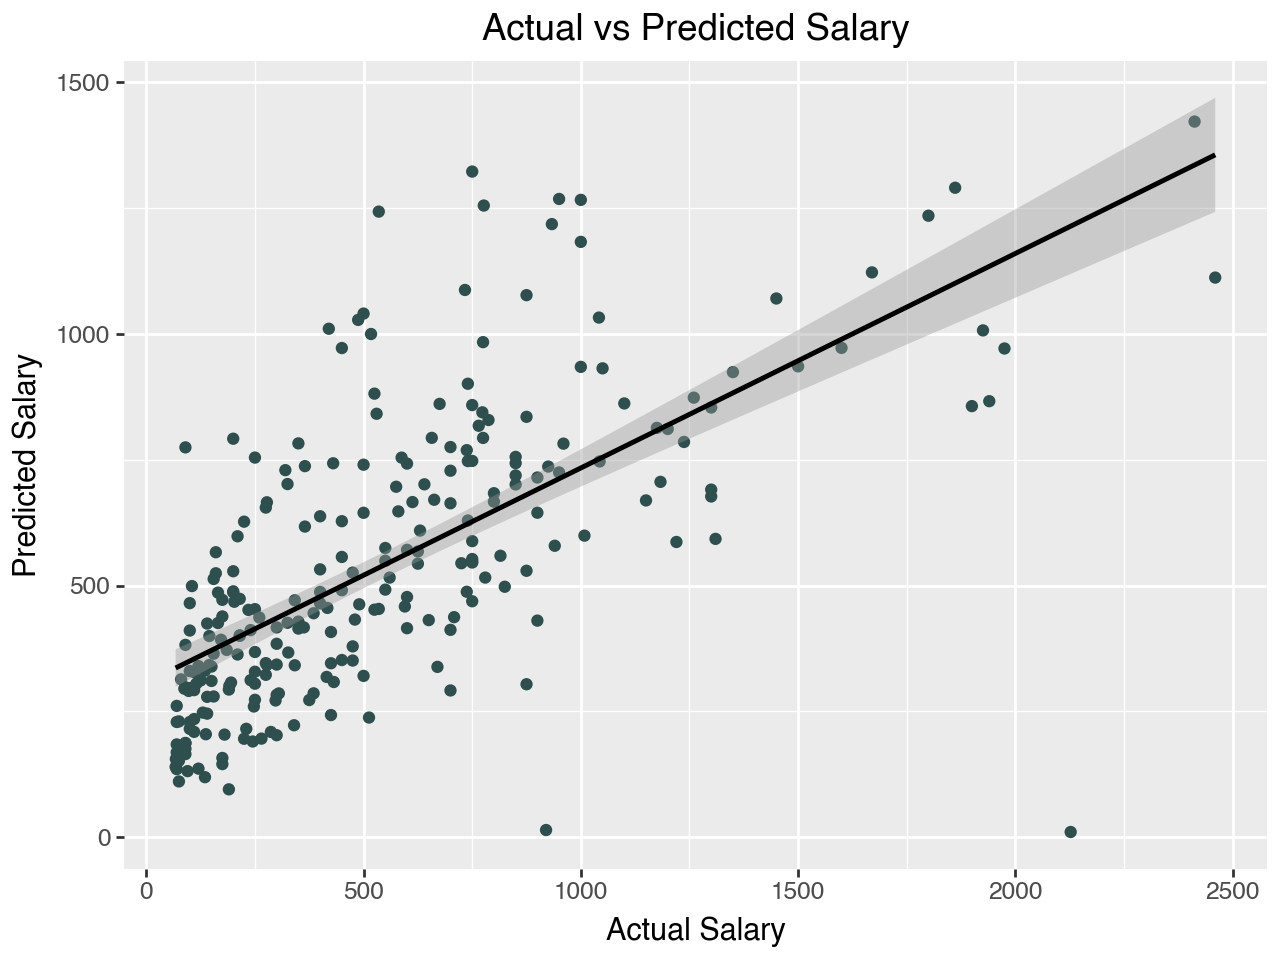

In [333]:
# create plot

plot_df = hitters[["Salary"]]
plot_df["y_pred"] = y_pred

(ggplot(plot_df, aes(x = "Salary", y = "y_pred")) 
 + geom_point(color = "darkslategray")
 + geom_smooth(method = "lm")
 + labs(x = "Actual Salary", y = "Predicted Salary", title = "Actual vs Predicted Salary"))


The final and best model is the elastic net model with an lambda value of 10 and an l1_ratio value of 1. The calculated MSE for the best model is 100729.64. Out of all MSE values calulated with different models, this produces the lowest MSE, indicating that this model is performing better when predicting the salary.

The scatterplot above shows that the values tend to follow the trend of the line of best fit, however they do not perfectly follow the line of best fit. Although not perfect, it still captures the overall postive correlation of the actual versus predicted values. 

